# Syntethic dataset example

- Real LFP
- Inlcude additional plots (row correlation)

- Dataset LAVADE
- Dataset section
- Dagtaset comb

- Move derivation of derivatives to SI

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr

import seaborn as sns

from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.cross_decomposition import PLSRegression

import random
# Initialize the random seed to ensure reproducibility of the results in the paper
random.seed(10)

# Test your implementations of the skewness and kurtosis etc. 
from scipy.stats import skew
from scipy.stats import kurtosis

from jax import jacfwd
import jax.numpy as jnp

import src.featlin
from src.featlin import regress_linearized_coeff
from src.featlin import jax_moment
from src.featlin import linearization_plots
from src.featlin import generate_target_values

In [2]:
# Colorblind safe palette from: https://gka.github.io/palettes/#/26|s|00429d,96ffea,ffffe0|ffffe0,ff005e,93003a|1|1
# 

# Previously I used, but not good for colorblind people.
# cmap = sns.color_palette("icefire", as_cmap=True)
# colors = [
#    '#00429d', '#1649a0', '#2351a4', '#2d58a7', 
#    '#3660ab', '#3e67ae', '#456fb2', '#4d77b5', 
#    '#547fb8', '#5b87bb', '#618fbf', '#6896c2', 
#    '#6f9ec5', '#77a6c8', '#7eafcb', '#85b7ce', 
#    '#8dbfd1', '#95c7d3', '#9ecfd6', '#a7d7d8', 
#    '#b1dfdb', '#bbe6dd', '#c7eedf', '#d4f5e0', 
#    '#e5fbe1', '#ffffe0'] 

# colors = ['#332bb3', '#3936b9', '#423fbd', '#4e47bf', '#5b4dbf', '#6953be', '#7657bb', '#845cb7', '#915fb2', '#9e63ad', '#aa66a6', '#b56a9f', '#c06e97', '#ca738f', '#d37887', '#dc7e7e', '#e48575', '#eb8d6d', '#f19764', '#f7a25b']
colors = ['#332bb3', '#4a31b5', '#5d37b6', '#6d3db7', '#7c43b7', '#8a49b6', '#964fb5', '#a256b3', '#ad5db1', '#b764b0', '#c16cae', '#ca75ad', '#d27eac', '#d989ab', '#e094aa', '#e7a1ab', '#ecafac', '#f0beae', '#f4cfb0', '#f6e1b4']
# colors = ['#00006a', '#280a76', '#411681', '#561f8b', '#692893', '#7c3099', '#8d379f', '#9e3ea2', '#ad46a5', '#bc4ea6', '#c956a6', '#d560a6', '#e06aa4', '#ea76a1', '#f2839d', '#f99299', '#fea393', '#ffb58d', '#ffc985', '#ffdf7b']
cmap = clr.LinearSegmentedColormap.from_list('Blue-light cb-safe', colors, N=256)
color_list = ['#0051a2', '#97964a', '#f4777f', '#93003a']

In [3]:
#@RDB: JS: This is all a little bit random. Do you have better ideas what we could do? Something that is motivated by a real system and also relevant? 

# Implement battery data here and showcase it for the case of a known relationship 
#   (aka. if X is this from the real world, where many things are simply not that gaussian, and we assume that y is produced by this underlying function (add noise to y), 
#   then our method does this and that

# Somewhat arbitrary functions to represent some quantity we were able to measure
fun_meas = [
    lambda a : a,
    lambda a : a**2,
    ]

fmeas_names = [
    'linear',
    'quadratic',
    'log'
    ]
    
# True underlying relationship between the measurements and some quantity we ewould like to recover/predict from measurements
fun_target = [
    lambda a : np.mean(a),
    lambda a : np.sum(a**2),
    lambda a : np.var(a),
    lambda a : skew(a),
    lambda a : kurtosis(a),
    ]

# JAX numpy wrapper target function  to allow for autodifferentiation
fun_targetj = [
    lambda a : jnp.mean(a),
    lambda a : jnp.sum(a**2),
    lambda a : jnp.var(a),
    lambda x: jax_moment(x,3)/((jax_moment(x,2))**(3/2)),
    lambda x: jax_moment(x,4)/(jax_moment(x,2)**2)-3
    ]
    #lambda a : jnp.sum(jnp.sqrt(a))

fun_target_names = [
    'Sum',
    'Sum of Squares',
    'Variance', 
    'Skewness',
    'Kurtosis',
    ]

# What if the relationship is actually a combination fo different functions
# Combinations based of the functions above to obtain non-linear functions of different complexity
# This is expected to show limits of the methodology
fun_target_comb = [
    lambda  a : 5*fun_target[0](a) + fun_target[1](a),
    lambda  a : 3*fun_target[2](a) + fun_target[0](a),
    lambda  a : fun_target[2](a) * fun_target[4](a),
    lambda  a : fun_target[1](a) * fun_target[5](a)
    ]
fun_target_combj = [
    lambda  a : 5*fun_targetj[0](a) + fun_targetj[1](a),
    lambda  a : 3*fun_targetj[2](a) + fun_targetj[0](a),
    lambda  a : fun_targetj[1](a) * fun_targetj[3](a),
    lambda  a : fun_targetj[3](a) * fun_targetj[4](a)
    ]
ftarget_comb_names = [
    '5*\sum_{i=1}^n x_i + \sum_{i=1}^n x_i^2',
    '3*\text{var}(\mathbf{x}) + \sum_{i=1}^n x_i',
    '\sum_{i=1}^n x_i^2 * \text{skewness}(\mathbf{x})',
    '\text{skewneww}(\mathbf{x}) * \text{kurtosis}(\mathbf{x})'
]

In [40]:
# Load the LFP Dataset
lfp_df = pd.read_csv('lfp_slim.csv', index_col=0)

X_lfp = np.array(lfp_df.iloc[:, 0:1000])
X_lfp = X_lfp[:, ::-1]
y_lfp_true = np.array(lfp_df.iloc[:, 1000])
x_lfp = np.linspace(2.0, 3.5, 1000)

X_lfp_train = np.array(X_lfp[lfp_df.iloc[:, 1002]==0, :])
y_lfp_train_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==0])
X_lfp_test = np.array(X_lfp[lfp_df.iloc[:, 1002]==1, :])
y_lfp_test_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==1])
X_lfp_test2 = np.array(X_lfp[lfp_df.iloc[:, 1002]==2, :])
y_lfp_test2_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==2])

y_lfp_train = np.zeros([X_lfp_train.shape[0], 5, 1])
for j in range(len(fun_targetj)): 
    y_lfp_train[:, j, 0] = generate_target_values(X_lfp_train[:, :], fun_targetj[j], percentage_range_x_to_t=[0,1])

labels_lfp = {'xdata_label': 'Voltage (V)', 'ydata_label': r'$\Delta \mathbf{Q}_{100\mathrm{-}10}$ (Ah)', 'row_label': 'Battery number'}

(2.0, 3.5)

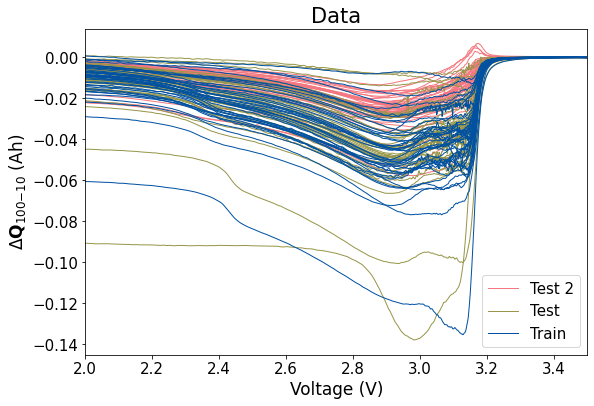

In [49]:
# Make Dataset Plots. 
fig, ax = plt.subplots(figsize=(9,6))
ax = src.featlin.plot_x_tt2(ax, x_lfp, X_lfp_train, color_list[0], labels_lfp['xdata_label'], labels_lfp['ydata_label'], zorder=3)
ax = src.featlin.plot_x_tt2(ax, x_lfp, X_lfp_test, color_list[1], labels_lfp['xdata_label'], labels_lfp['ydata_label'], label_data='Test', zorder=2)
ax = src.featlin.plot_x_tt2(ax, x_lfp, X_lfp_test2, color_list[2], labels_lfp['xdata_label'], labels_lfp['ydata_label'], label_data='Test 2', zorder=1)

ax.set_title('Data')

ax.set_xlim(2.0, 3.5)

In [45]:
np.arange(X_lfp_train.T.shape[1])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40])

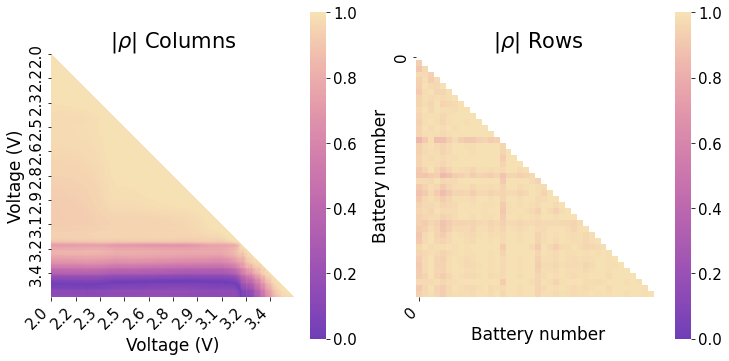

In [44]:
# Correlations: 
fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0] = src.featlin.plot_corrheatmap(axs[0], x_lfp, X_lfp_train, cmap, labels_lfp['xdata_label'], labels_lfp['xdata_label'], r'$|\rho|$ Columns')
axs[1] = src.featlin.plot_corrheatmap(axs[1], np.arange(X_lfp_train.T.shape[1]), X_lfp_train.T, cmap, labels_lfp['row_label'], labels_lfp['row_label'], r'$|\rho|$ Rows')

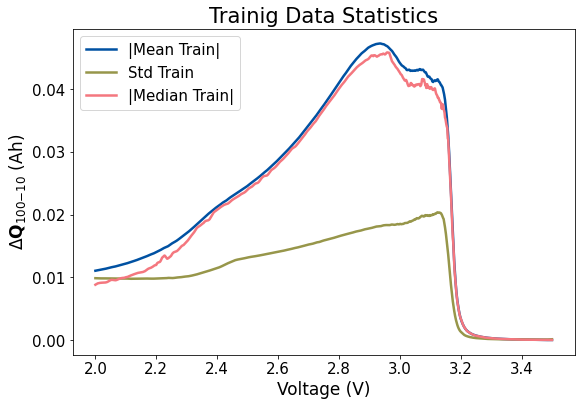

In [43]:
# Data Stats
fig, ax = plt.subplots(figsize=(9,6))
ax = src.featlin.plot_stats(ax, x_lfp, X_lfp_train, color_list[0], color_list[1], color_list[2], labels_lfp['xdata_label'], labels_lfp['ydata_label'])
ax.set_title('Trainig Data Statistics')
plt.show()

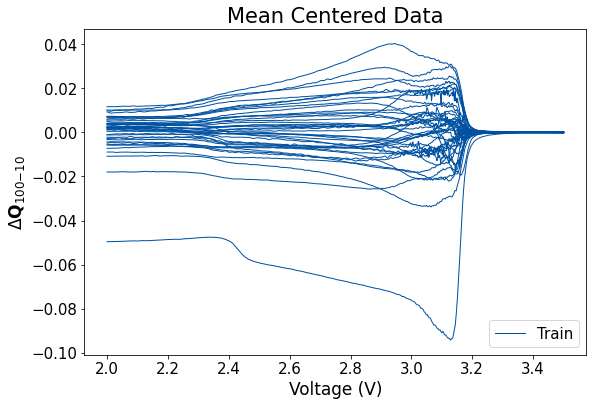

In [36]:
fig, ax = plt.subplots(figsize=(9,6))
ax = src.featlin.plot_x_tt2(ax, x_lfp, X_lfp_train-np.mean(X_lfp_train, axis=0), color_list[0], labels_lfp['xdata_label'], labels_lfp['ydata_label'], label_data='Train')
ax.set_title('Mean Centered Data')
plt.show()

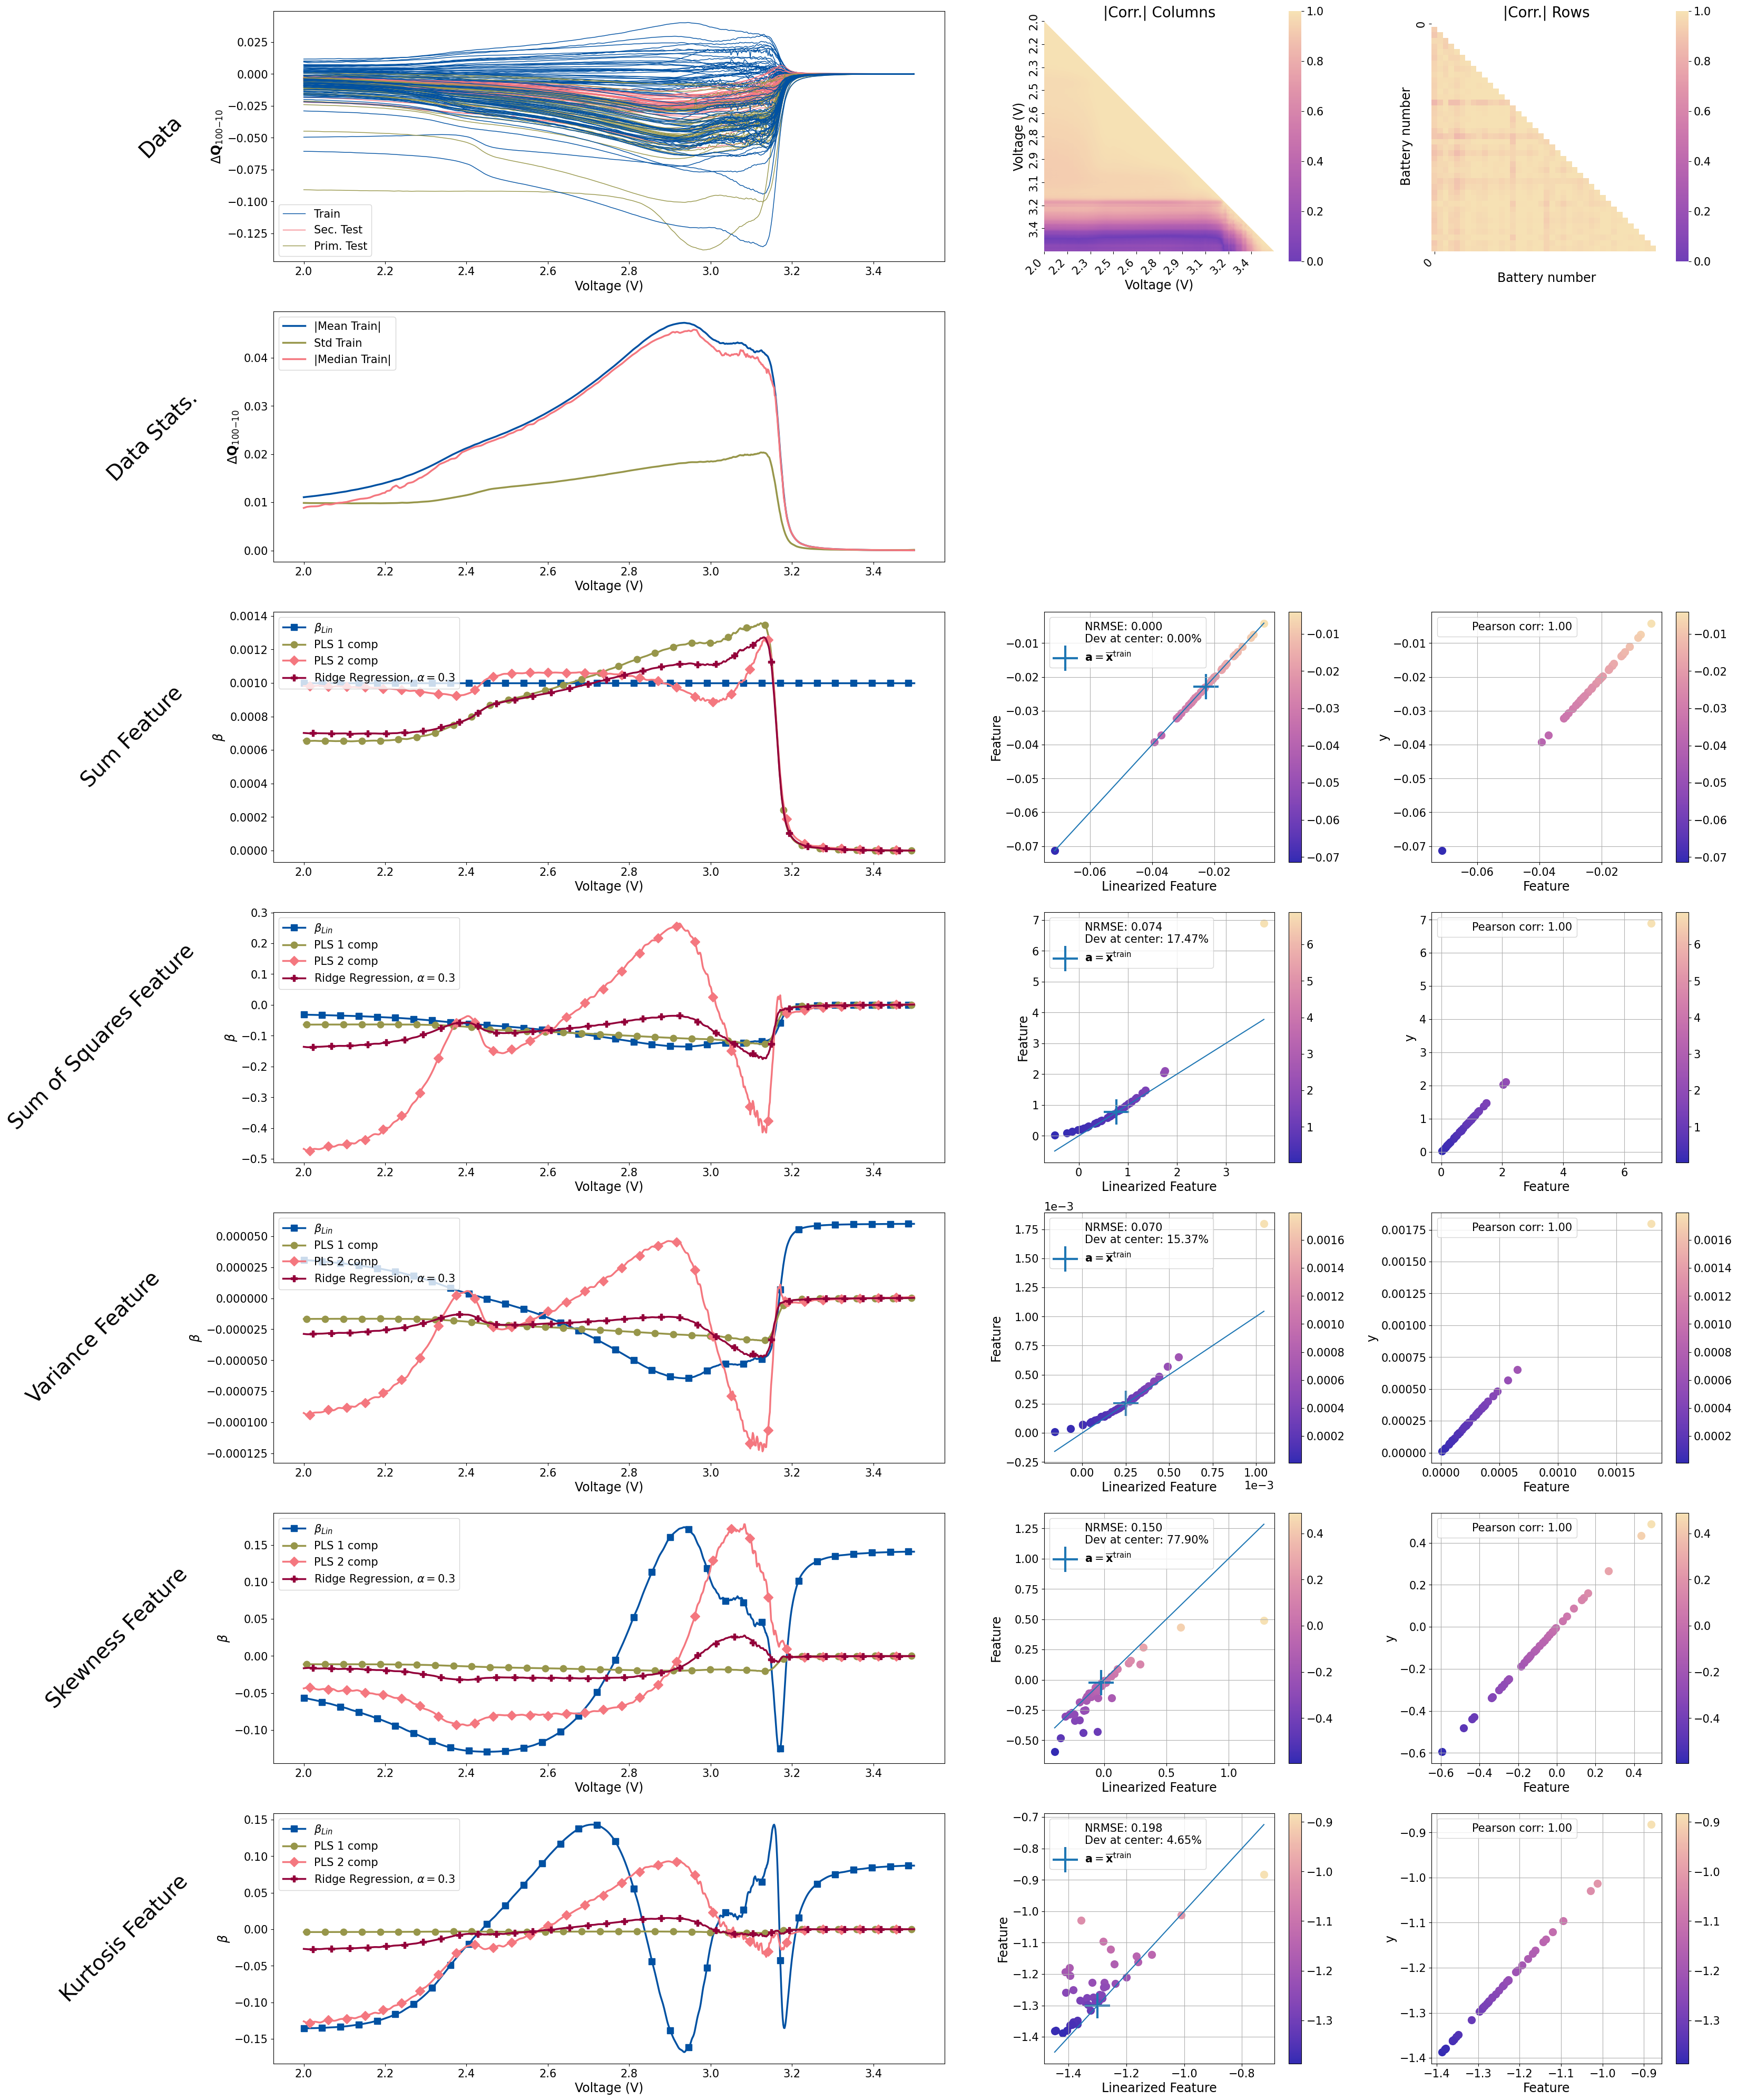

In [12]:
from importlib import reload
reload(src.featlin)
from src.featlin import linearization_plots

models = [
    PLSRegression(n_components=1, tol=1e-7, scale=False),
    PLSRegression(n_components=2, tol=1e-7, scale=False),
    # PLSRegression(n_components=3, tol=1e-7, scale=False), 
    Ridge(alpha=0.3)
]
model_names = [
    'PLS 1 comp',
    'PLS 2 comp',
    # 'PLS 3 comp',
    r'Ridge Regression, $\alpha=0.3$'
]

fig, axs = linearization_plots(x_lfp,  X_lfp_train, y_lfp_train, fun_targetj, fun_target_names, models, model_names, labels_lfp, cmap, show=False)

# Plot Test, Test 2 into axs[0, 0]\
axs[0, 0].plot(x_lfp, X_lfp_test2[:, :].T, label='Sec. Test', lw=1, color=color_list[2])
axs[0, 0].plot(x_lfp, X_lfp_test[:, :].T, label='Prim. Test', lw=1, color=color_list[1])
axs[0, 0].plot(x_lfp, X_lfp_train[:, :].T, label='Train', lw=1, color=color_list[0])
handles, labels = axs[0, 0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs[0, 0].legend(by_label.values(), by_label.keys(), loc=3)

plt.show()

# RDB What would be useful in your opinoin?
# Insert additional plots for  axs[1, 1] and axs[1, 2] in here. 
# Correlation of each column to y
# Train and test dataset correlations ( one plot per test)


In [13]:
def reject_outliers(data, m = 2.):
    '''
    https://stackoverflow.com/questions/11686720/is-there-a-numpy-builtin-to-reject-outliers-from-a-list
    Answer from Benjamin Bannier
    '''
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m], s<m

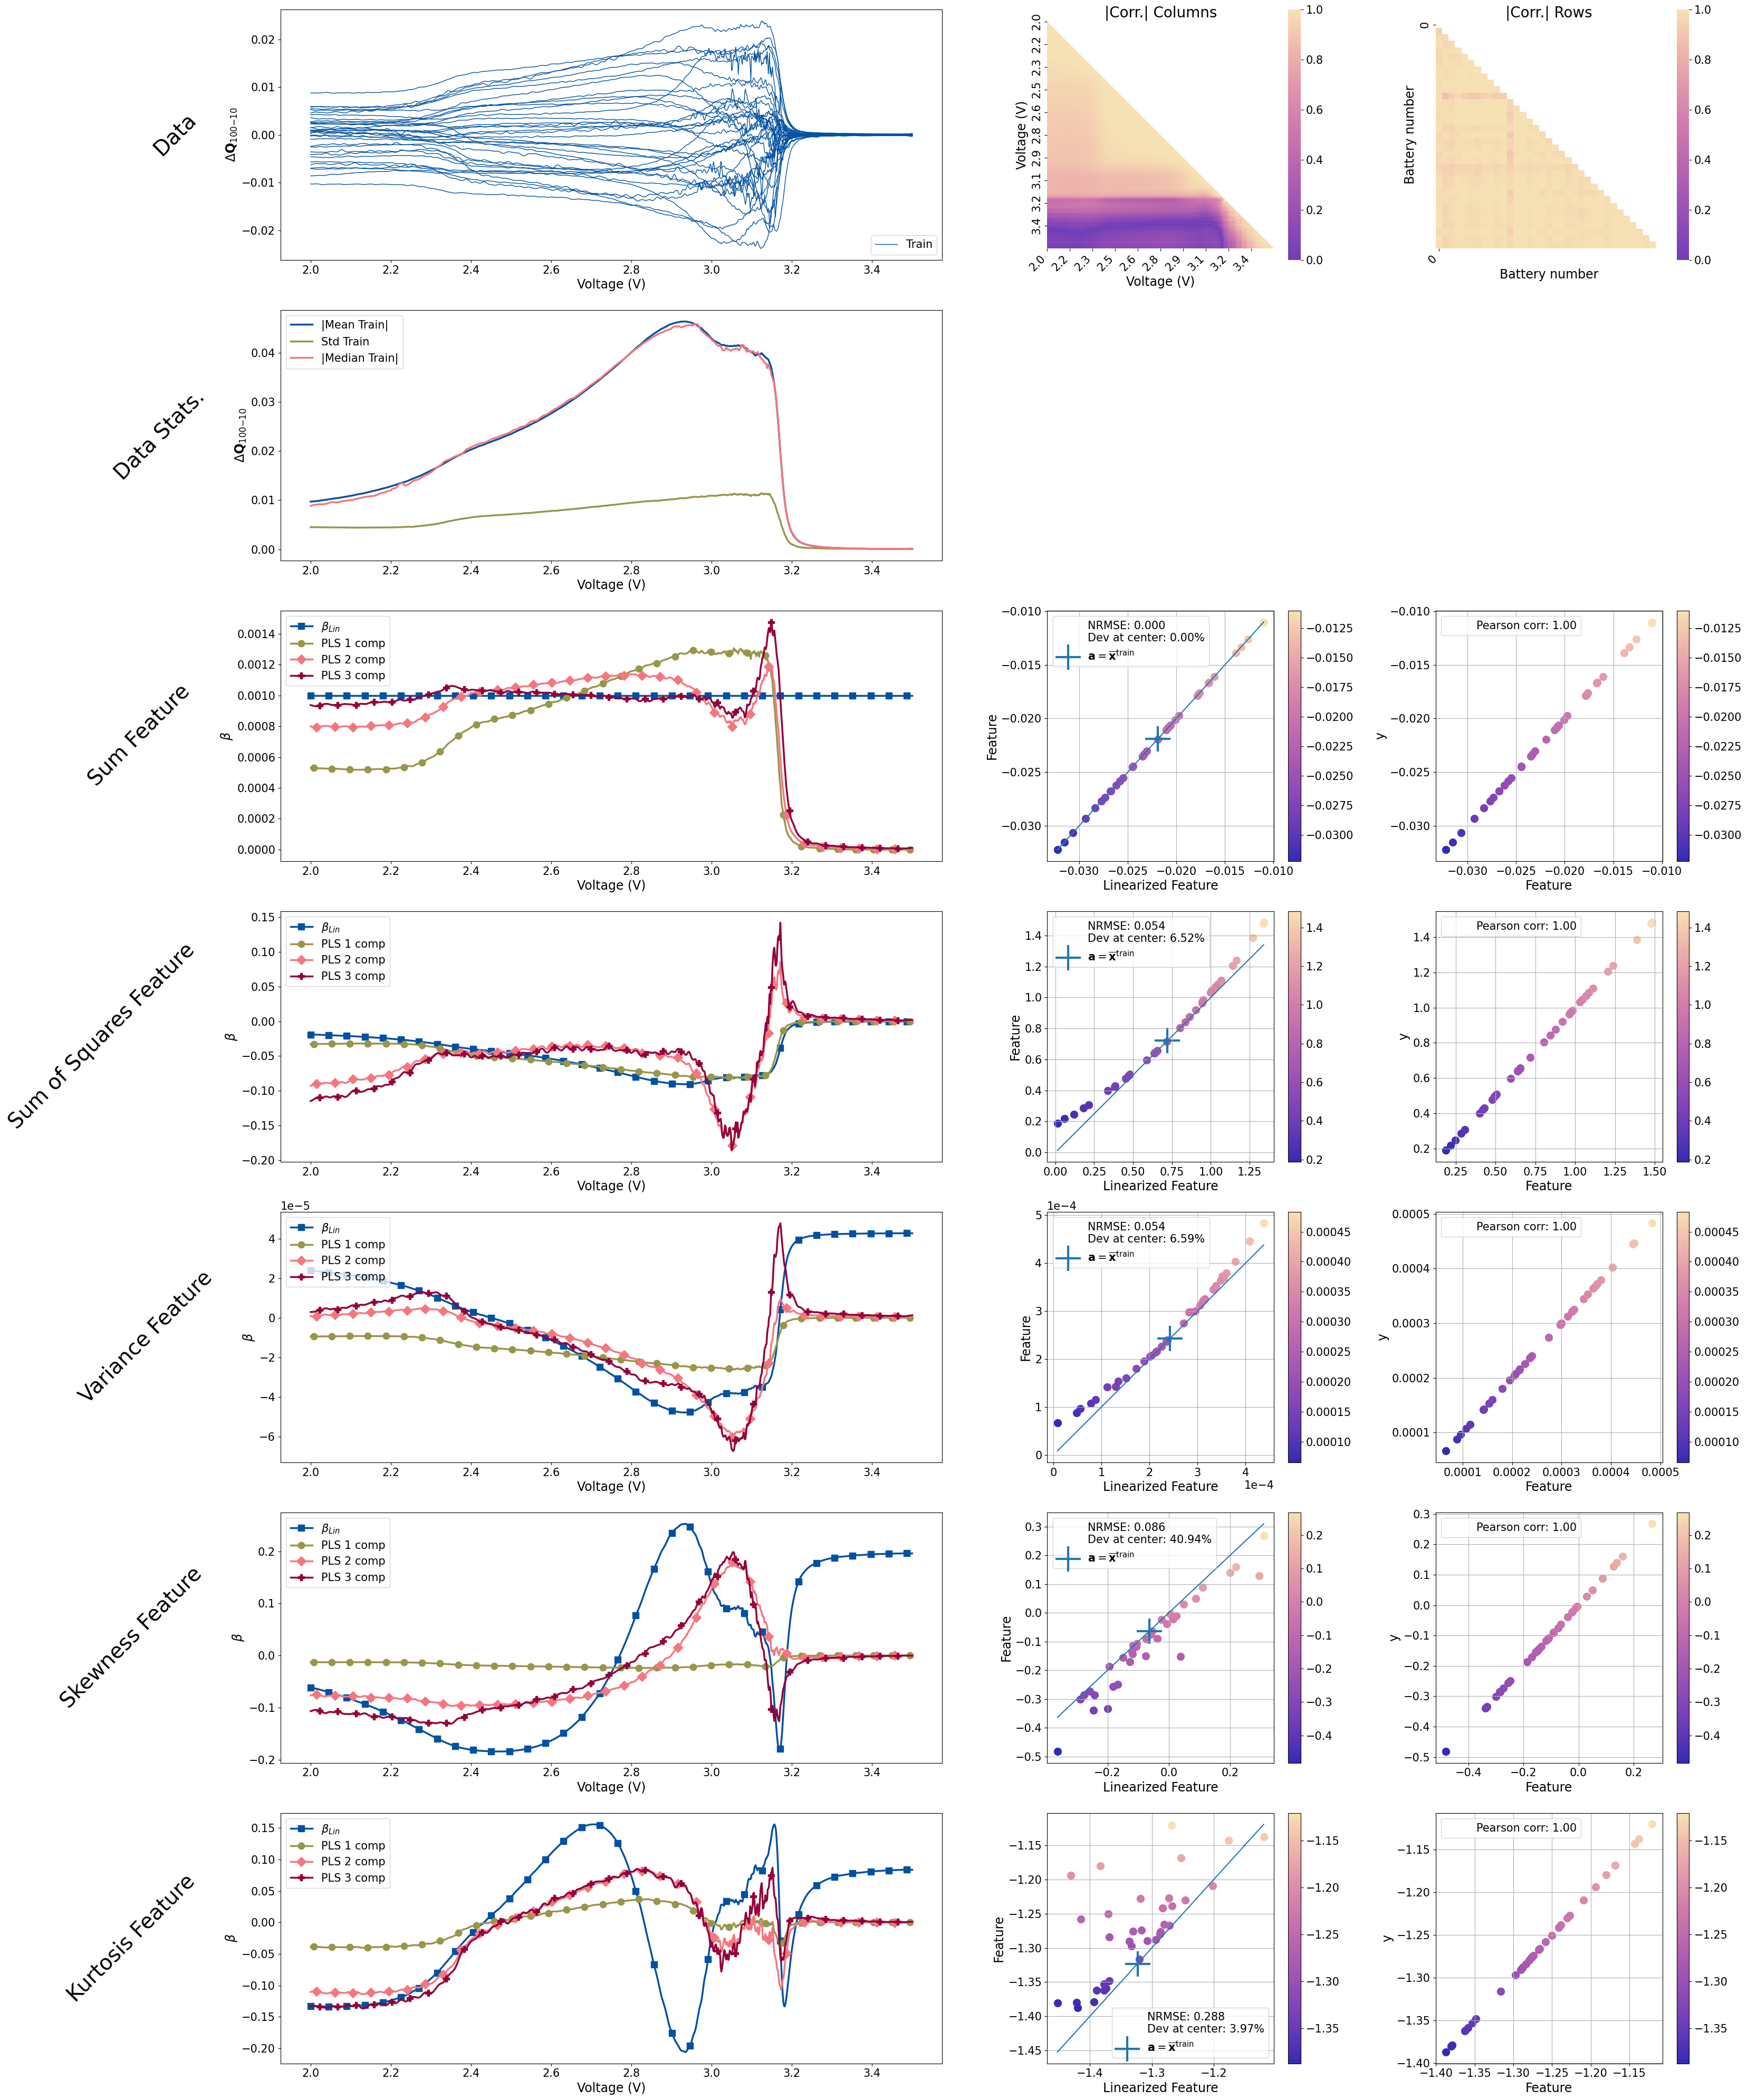

In [14]:
# Now without the outlier's (; 
X_lfp_train_filtered_mean, ind =  reject_outliers(np.mean(X_lfp_train, axis=1), m = 2.5)


models = [
    PLSRegression(n_components=1, tol=1e-7, scale=False),
    PLSRegression(n_components=2, tol=1e-7, scale=False),
    PLSRegression(n_components=3, tol=1e-7, scale=False), 
    #Ridge(alpha=0.3)
]
model_names = [
    'PLS 1 comp',
    'PLS 2 comp',
    'PLS 3 comp',
    #r'Ridge Regression, $\alpha=0.3$'
]

fig, axs = linearization_plots(x_lfp,  X_lfp_train[ind, :], y_lfp_train[ind, :], fun_targetj, fun_target_names, models, model_names, labels_lfp, cmap, show=False)

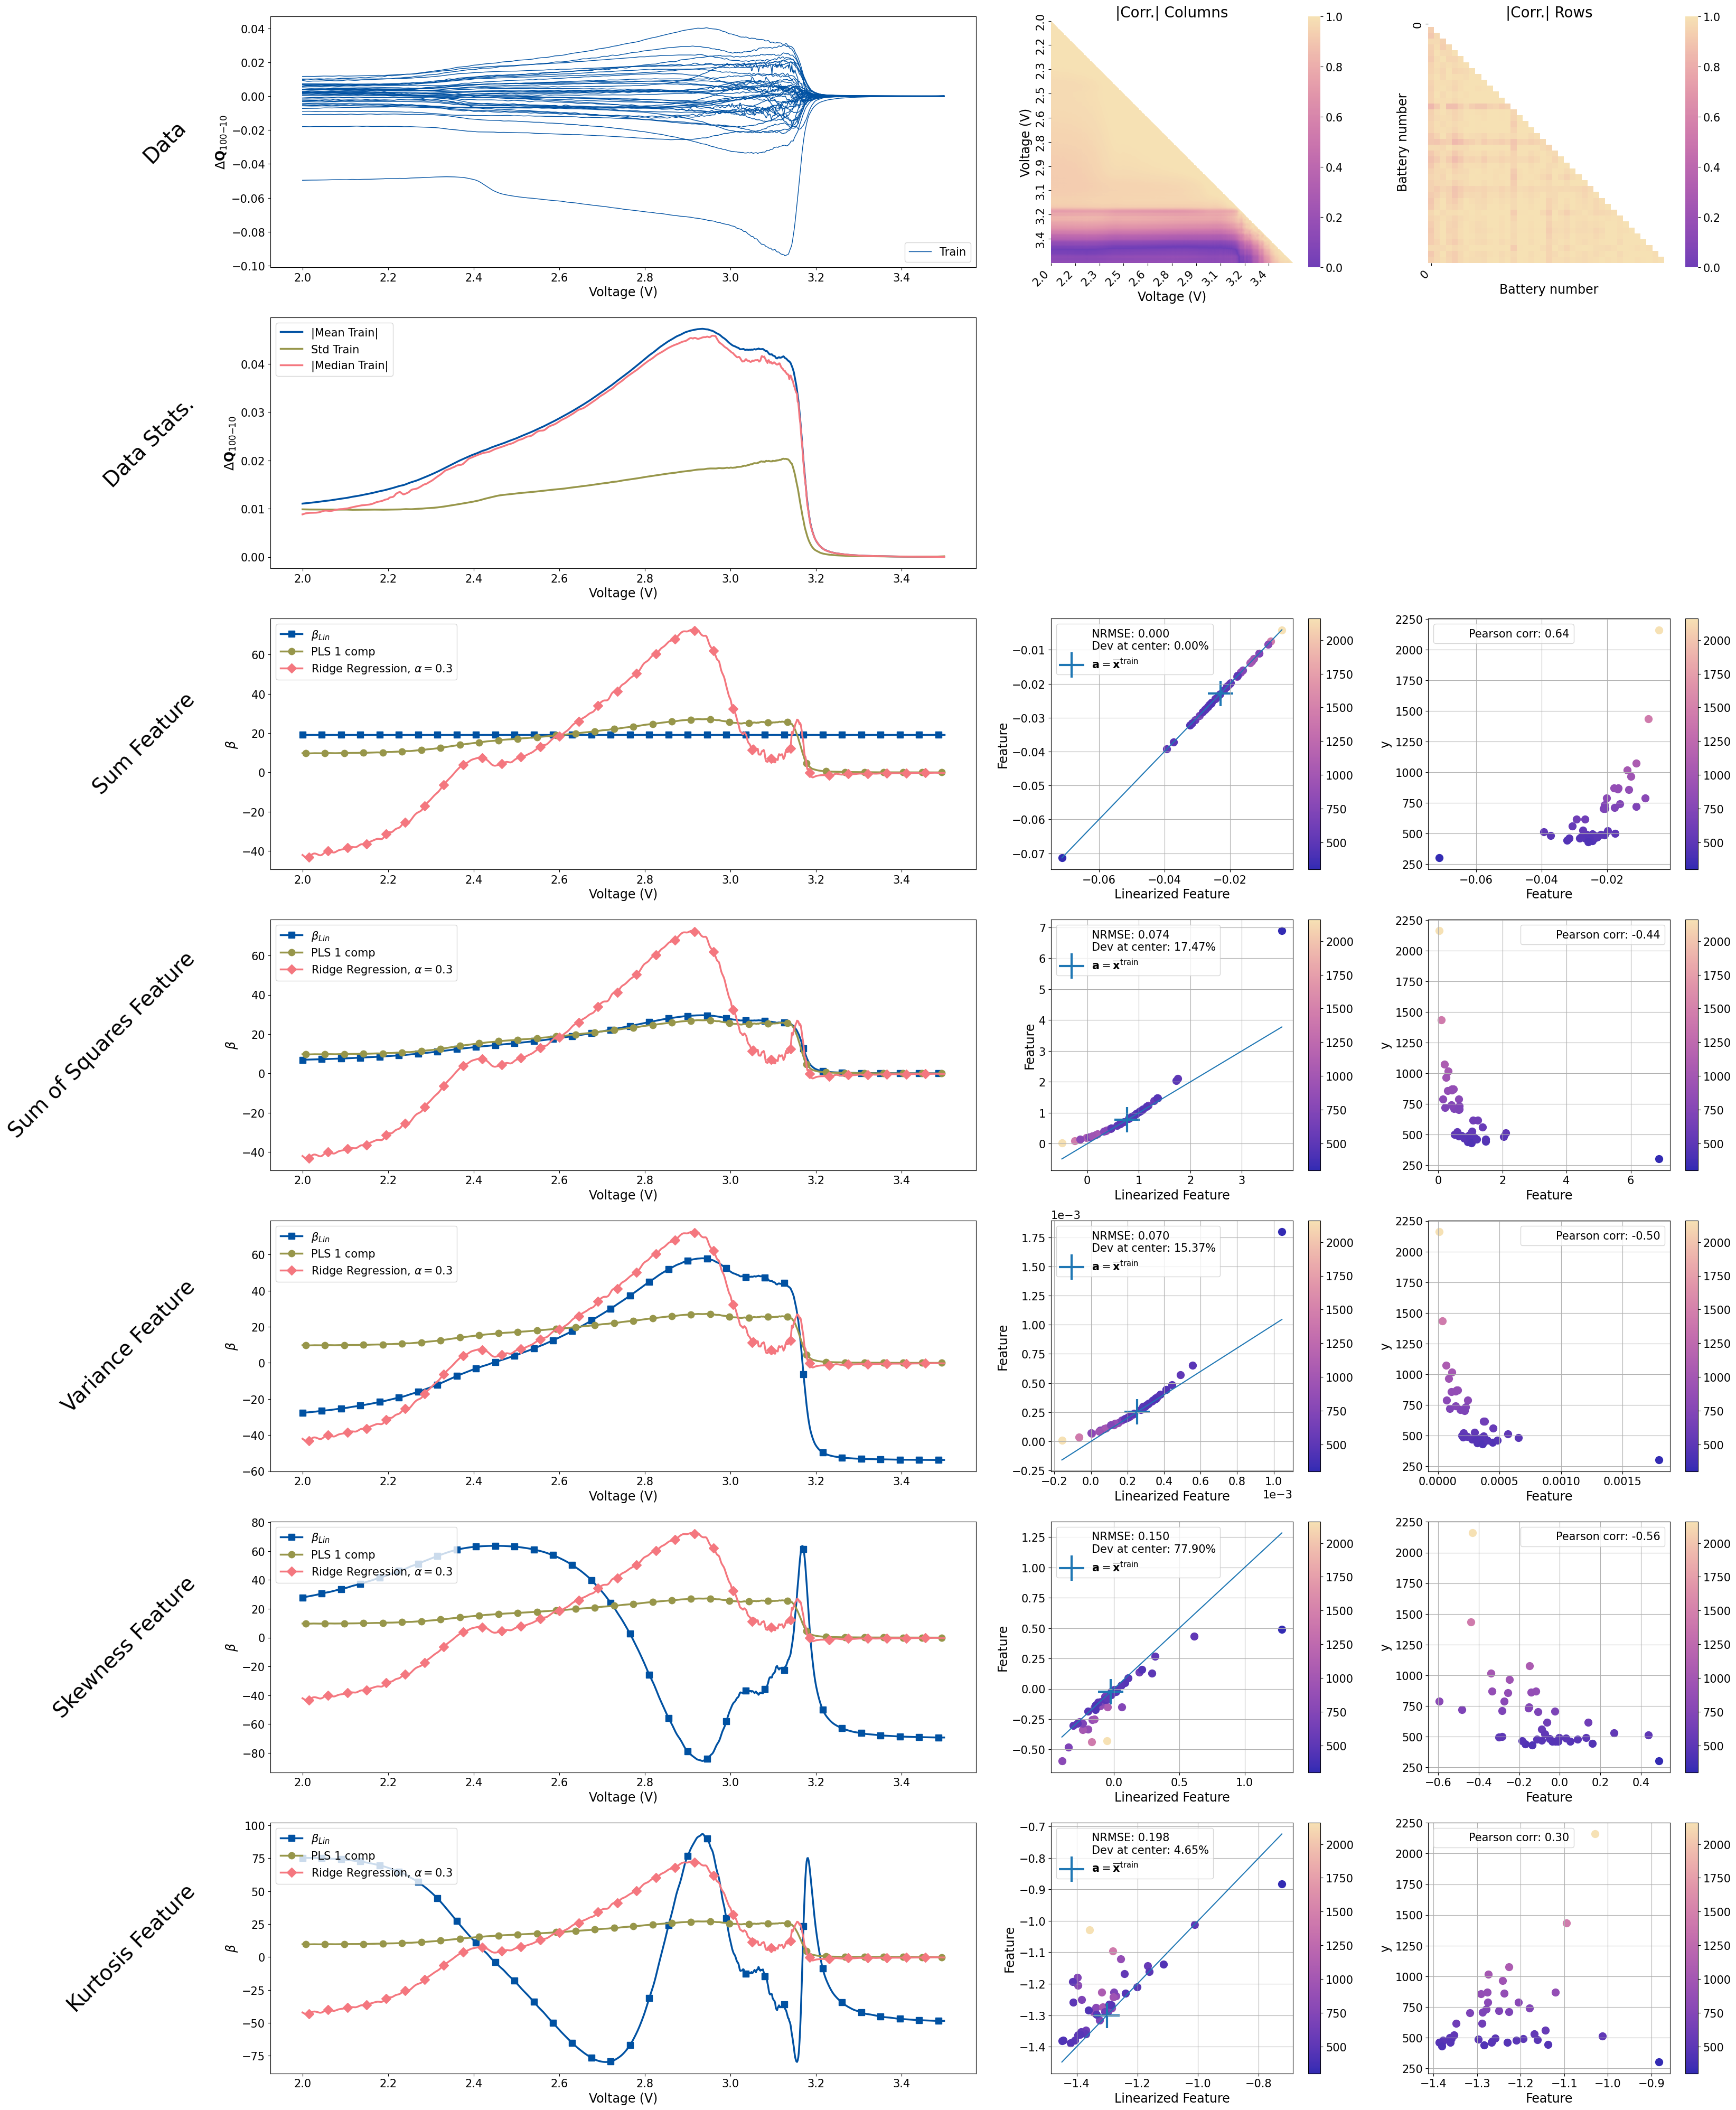

In [15]:
# LFP with real labels (:
reload(src.featlin)
from src.featlin import linearization_plots

models = [
    PLSRegression(n_components=1, tol=1e-7, scale=False),
    # PLSRegression(n_components=2, tol=1e-7, scale=False),
    #PLSRegression(n_components=3, tol=1e-7, scale=False), 
    Ridge(alpha=0.3)
]
model_names = [
    'PLS 1 comp',
    # 'PLS 2 comp',
    #'PLS 3 comp',
    r'Ridge Regression, $\alpha=0.3$'
]

fig, axs = linearization_plots(x_lfp,  X_lfp_train, y_lfp_train_true, fun_targetj, fun_target_names, models, model_names, labels_lfp, cmap, show=False)

In [16]:
def plot_axs(x,  X_train_, X_test_, y_train_, fun_targetj, alpha):
    ''' Function to create plot of data and regression coefficients
    '''
    colors = ['#0051a2', '#97964a', '#f4777f', '#93003a']
    rows = len(fun_targetj) + 2
    columns = X_train_.shape[2]+1
    figsize = [10*columns, 6*rows]

    fig, axs = plt.subplots(rows, columns, figsize=figsize, sharex=True)

    axs[0, 0].plot(x, X_train_[:, :, 0].T, label='Train Data', lw=1, color=colors[0])
    axs[0, 0].plot(x, X_test_[:, :, 0].T, label='Test Data', lw=1, color=colors[1])
    axs[0, 1].plot(x, X_train_[:, :, 0].T, label='Train Data', lw=1, color=colors[0])
    axs[0, 1].plot(x, X_test_[:, :, 0].T, label='Test Data', lw=1, color=colors[1])
    # axs[0, 1].plot(x, X_train_[:, :, 1].T, label='Train Data', lw=1, color=colors[0])
    # axs[0, 1].plot(x, X_test_[:, :, 1].T, label='Test Data', lw=1, color=colors[1])
    # axs[0, 2].plot(x, X_train_[:, :, 2].T, label='Train Data', lw=1, color=colors[0])
    # axs[0, 2].plot(x, X_test_[:, :, 2].T, label='Test Data', lw=1, color=colors[1])
    axs[1, 0].plot(x, np.abs(np.mean(X_train_[:, :, 0].T, axis=1)), label='|Mean Train|', lw=1, color=colors[0])
    axs[1, 0].plot(x, np.std(X_train_[:, :, 0].T, axis=1), label='Std Train', lw=1, color=colors[1])
    axs[1, 1].plot(x, np.abs(np.mean(X_train_[:, :, 0].T, axis=1)), label='|Mean Train|', lw=1, color=colors[0])
    axs[1, 1].plot(x, np.std(X_train_[:, :, 0].T, axis=1), label='Std Train', lw=1, color=colors[1])
    axs[1, 0].legend()
    axs[1, 1].legend()
    
    for i in range(X_train_.shape[2]):
        handles, labels = axs[0, i].get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        axs[0, i].legend(by_label.values(), by_label.keys(), loc=2, fontsize=22)

    for i in range(X_train_.shape[2]):
        for j in range(y_train_.shape[1]):
            X_train = X_train_[:, :, i]
            y_train = y_train_[:, j, i]
            pls1 = PLSRegression(n_components=1, tol=1e-7, scale=False).fit(X_train, y_train-y_train.mean())
            pls2 = PLSRegression(n_components=2, tol=1e-7, scale=False).fit(X_train, y_train-y_train.mean())
            pls3 = PLSRegression(n_components=3, tol=1e-7, scale=False).fit(X_train, y_train-y_train.mean())
            pls4 = PLSRegression(n_components=4, tol=1e-7, scale=False).fit(X_train, y_train-y_train.mean())
            rr = Ridge(alpha=alpha).fit(X_train, y_train-y_train.mean())

            x_hat, lin_coef_, lin_const_coef = regress_linearized_coeff(X_train, y_train, fun_targetj[j])
            axs[j+2, i].plot(x, lin_coef_.reshape(-1), label=r'$\beta_{Lin}$', lw=2.5, color=colors[0], marker="s", markevery=(1, 30),  markersize=9)
            axs[j+2, i+1].plot(x, lin_coef_.reshape(-1), label=r'$\beta_{Lin}$', lw=2.5, color=colors[0], marker="s", markevery=(1, 30),  markersize=9)
            axs[j+2, i].plot(x, pls1.coef_, label=r'$\beta_{PLS}$, 1 Component', lw=2.5, color=colors[1], marker="o", markevery=(10, 30), markersize=9)
            axs[j+2, i].plot(x, pls2.coef_, label=r'$\beta_{PLS}$, 2 Component', lw=2.5, color=colors[2], marker="D", markevery=(15, 30), markersize=9)
            axs[j+2, i+1].plot(x, pls2.coef_, label=r'$\beta_{PLS}$, 2 Component', lw=2.5, color=colors[2], marker="D", markevery=(15, 30), markersize=9)
            axs[j+2, i+1].plot(x, pls3.coef_, label=r'$\beta_{PLS}$, 3 Component', lw=2.5, color=colors[3], marker="D", markevery=(20, 30), markersize=9)
            axs[j+2, i+1].plot(x, pls4.coef_, label=r'$\beta_{PLS}$, 4 Component', lw=2.5, color=colors[1], marker="D", markevery=(25, 30), markersize=9)
            axs[j+2, i].plot(x, rr.coef_, label=r'$\beta_{RR}$  $\lambda=0.5$', lw=2.5, color=colors[3], marker="P", markevery=(20, 30),  markersize=9)
            
            # axs.grid()
            handles1, labels1 = axs[j+1, i].get_legend_handles_labels()
            by_label1 = dict(zip(labels1, handles1))
            handles2, labels2 = axs[j+1, i+1].get_legend_handles_labels()
            by_label2 = dict(zip(labels2, handles2))
            axs[j+2, i].legend(by_label1.values(), by_label1.keys(), loc=2, fontsize=16)
            axs[j+2, i+1].legend(by_label2.values(), by_label2.keys(), loc=2, fontsize=16)
            
            axs[j+2, i].set_title(fun_target_names[j])
            axs[j+2, i+1].set_title(fun_target_names[j])

    plt.tight_layout()
    plt.show()
            
    return None

In [17]:
# IPython Libraries
import IPython
import ipywidgets
from ipywidgets import interact, fixed

scaler = preprocessing.StandardScaler().fit(X_lfp_train)
X_scaled = scaler.transform(X_lfp_train)
interact(plot_axs, x=fixed(np.linspace(3.5, 2.0, 1000)),  X_train_=fixed(np.expand_dims(X_lfp_train, axis=2)), 
        X_test_=fixed(np.expand_dims(X_lfp_test, axis=2)), y_train_=fixed(y_lfp_train), fun_targetj=fixed(fun_targetj),
        alpha=ipywidgets.FloatLogSlider(value = 0.5,
                                    base = 2,
                                    min=-10, 
                                    max=10, 
                                    step=0.0001, 
                                    description='Alpha RR',
                                    continuous_update=True)
                                    )

interactive(children=(FloatLogSlider(value=0.5, base=2.0, description='Alpha RR', max=10.0, min=-10.0, step=0.…

<function __main__.plot_axs(x, X_train_, X_test_, y_train_, fun_targetj, alpha)>

In [18]:
# Why don't the linear methods point into the directions that would be ideal?  
# The effect of 'outliers' ?

# Even in an ideal world this will not work too well. 
# Reasons: 
# 1. Nullspace of the data, 
# 2. The way of regularization will affed the shape of the coefficiencts a lot. 
# IF there's some linear order, the algorithms will always learn coefficients that have a similar shape as the data!
# How much are the algorithms affected by outliers? 
# How much are the algorithms affected by not standardizing the data
# How much does correlation between columns affect the results? 

# --> Conclusion: Interesting new perspective on interpretation of regression coefficients. 
# How do regression coeffcieints compare with standardizartion and without?

# Negative regression coefficients: This is NOT an issue. Might be simply because of the y-y.mean(). 
# How and when does the sign of regression coefficients flip?


# Conclusions: It can give you some directions that might be interesting. 
# HOWEVER: Regression coefficients often look similar to the data... 
# Why is this the case? 
# --> Because the data is not standardized, we apply an implicicit preference larger weights on regions that with a larger mean/std 
# Thsi regiosn might also contiana more information, but deu to the way how regularization is done, if the regions where the magnitude of the data is smaller 
# doesnt carry significatly more information, those will go to zero//they might be eassier to regularize down.

# Common issues with such datasets: 
# Correlation of columns. 

# Hyperparamter: How to find the right hyperparamter?
# PLS with its integer hyperparamters might not be ideal

# Idea: Tune RR hyperparamter to optimize the fit of th regression coefficient with the feature as a measure. 
# (Metric based on the difference of the prediction, or simpoly apply some nullspace trick)

# You can get around the issue of hyperparamter tuning by only using the first 1 or 2 PLS components.

In [19]:
# Key Questions: 

# 1. Linear examples: Show that it works with CV
# 2. Nonlinear example, show that it wokrs with CV BUT might require nullspace. 
# 3. Was there a big eefect on whether the outlier is included or not? Leave it in if not.
# 3. How to do CV? RR or PLS? IF PLS: Can we just pretune and then finetune? 

